In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import time
import pickle
import os.path as osp
import tqdm
import pysam
import seaborn as sns
from matplotlib_venn import venn3, venn2

# U-to-C Mismatch Calculation
## Pysamstats result filtering

In [ ]:
# T_C
# A_G
BASES = ["A", "C", "G", "T"]
RNA_VER = 8
FILE = f"pysamstats_RNA00{RNA_VER}_csv.csv"

time_s = time.time()

RNA_dict = []
for i, chunk in enumerate(pd.read_csv(FILE, sep="\t", chunksize=100000)):
    
    valids = chunk[BASES].to_numpy().max(axis=1)>=20
    bases_chunk = chunk[['chrom', 'pos', 'ref', *BASES]]
    valid_chunk = bases_chunk[valids]
    T_chunk = valid_chunk.loc[chunk.ref=='A']
    c_error = (T_chunk['G']/T_chunk[BASES].sum(axis=1))>0.0 #0.4
    T_chunk_c_read = T_chunk[c_error]
   
    
    percentages = T_chunk_c_read[BASES].div(T_chunk_c_read[BASES].sum(axis=1), axis=0)
    percentages.columns = [c+'_perc' for c in percentages.columns]
    
    df = pd.concat([T_chunk_c_read, percentages], axis=1)
    T_chunk_c_read_list = df.to_dict('records')
    RNA_dict.extend(T_chunk_c_read_list)

time_e = time.time()
print(time_e-time_s)

In [ ]:
## consider both T_C and A_G(rev)

BASES = ["A", "C", "G", "T"]
RNA_VER = 8
FILE = f"pysamstats_RNA00{RNA_VER}_csv.csv"

time_s = time.time()

RNA_dict = []
header = True
mode = 'w'
T2C = f"./RNA00{RNA_VER}_table_T2C.csv"
A2G = f"./RNA00{RNA_VER}_table_A2G.csv"
T2C_A2G = f"./RNA00{RNA_VER}_table_T2C_A2G.csv"
chunksize = 10**6
with pd.read_csv(FILE, sep="\t", chunksize=chunksize) as reader:
    for i, chunk in enumerate(tqdm.tqdm(reader)):

        valids = chunk[BASES].to_numpy().max(axis=1) >= 20
        bases_chunk = chunk[['chrom', 'pos', 'ref', *BASES]]
        valid_chunk = bases_chunk[valids]

        # Case 1: Ref is T and Base is C
        T_chunk = valid_chunk.loc[chunk.ref == 'T']
        c_error = (T_chunk['C'] / T_chunk[BASES].sum(axis=1)) > 0 #0.20
        T_chunk_c_read = T_chunk[c_error]

        percentages_T2C = T_chunk_c_read[BASES].div(T_chunk_c_read[BASES].sum(axis=1), axis=0)
        percentages_T2C.columns = [c + '_perc' for c in percentages_T2C.columns]

        df_T2C = pd.concat([T_chunk_c_read, percentages_T2C], axis=1)
        df_T2C.to_csv(T2C, header = header, mode=mode, sep='\t', index=False)


        # Case 2: Ref is A and Base is G (reverse)
        A_chunk = valid_chunk.loc[chunk.ref == 'A']
        g_error = (A_chunk['G'] / A_chunk[BASES].sum(axis=1)) > 0 #0.20
        A_chunk_g_read = A_chunk[g_error]

        percentages_A2G = A_chunk_g_read[BASES].div(A_chunk_g_read[BASES].sum(axis=1), axis=0)
        percentages_A2G.columns = [c + '_perc' for c in percentages_A2G.columns]

        df_A2G = pd.concat([A_chunk_g_read, percentages_A2G], axis=1)
        df_A2G.to_csv(A2G, header = header, mode=mode, sep='\t', index=False)

        df_T2C_A2G = pd.concat([df_A2G, df_T2C], axis=0)
        df_T2C_A2G.to_csv(T2C_A2G, header = header, mode=mode, sep='\t', index=False)
        header = False
        mode = 'a'

time_e = time.time()
print(time_e - time_s)

In [ ]:
with open(f"./RNA002_dict_A2G.pkl", "rb") as f:
    RNA2A2G = pickle.load(f)


with open(f"./RNA008_dict_A2G.pkl", "rb") as f:
    RNA8A2G = pickle.load(f)
    
dict2 = pd.DataFrame(RNA2A2G)

dict8 = pd.DataFrame(RNA8A2G)

In [30]:
RNA002_T2C_A2G = pd.read_csv('RNA002_table_T2C_A2G.csv', sep="\t")

RNA008_T2C_A2G = pd.read_csv('RNA008_table_T2C_A2G.csv', sep="\t")

dict2 = pd.DataFrame(RNA002_T2C_A2G)
dict8 = pd.DataFrame(RNA008_T2C_A2G)

In [31]:
print(dict8.head())

  chrom    pos ref   A  C   G  T    A_perc    C_perc    G_perc    T_perc
0  chr1  14542   A  37  1   9  0  0.787234  0.021277  0.191489  0.000000
1  chr1  14562   A  45  0   2  0  0.957447  0.000000  0.042553  0.000000
2  chr1  14563   A  44  0   1  2  0.936170  0.000000  0.021277  0.042553
3  chr1  14574   A  37  0  10  0  0.787234  0.000000  0.212766  0.000000
4  chr1  14576   A  45  0   2  0  0.957447  0.000000  0.042553  0.000000


In [32]:
merged_df = pd.merge(dict2, dict8, on=['chrom', 'pos'], how='inner', suffixes=['_2', '_8']) 
merged_df.info()

merged_df.to_csv('/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G.csv', sep="\t", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537472 entries, 0 to 2537471
Data columns (total 20 columns):
 #   Column    Dtype  
---  ------    -----  
 0   chrom     object 
 1   pos       int64  
 2   ref_2     object 
 3   A_2       int64  
 4   C_2       int64  
 5   G_2       int64  
 6   T_2       int64  
 7   A_perc_2  float64
 8   C_perc_2  float64
 9   G_perc_2  float64
 10  T_perc_2  float64
 11  ref_8     object 
 12  A_8       int64  
 13  C_8       int64  
 14  G_8       int64  
 15  T_8       int64  
 16  A_perc_8  float64
 17  C_perc_8  float64
 18  G_perc_8  float64
 19  T_perc_8  float64
dtypes: float64(8), int64(9), object(3)
memory usage: 387.2+ MB


## Clair3 variant filtering

In [33]:
def extract_positions_from_vcf(vcf_file):
    positions = set()
    vcf = pysam.VariantFile(vcf_file)
    for record in vcf.fetch():
        positions.add((record.chrom, record.pos))
    return positions

csv_file = '/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G.csv'
csv_data = pd.read_csv(csv_file, sep="\t")

csv_data.columns = csv_data.columns.str.strip()

print("Columns in CSV:", csv_data.columns)

vcf_file = '/work/Genometechlab/neda/clair/RNA004_sup_vcf/merge_output.vcf.gz'
vcf_positions = extract_positions_from_vcf(vcf_file)

csv_positions = set(zip(csv_data['chrom'], csv_data['pos']))
matching_positions = csv_positions.intersection(vcf_positions)
num_matching_positions = len(matching_positions)

cleaned_csv_data = csv_data[~csv_data[['chrom', 'pos']].apply(tuple, axis=1).isin(matching_positions)]

cleaned_csv_file = '/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G_cleaned_vcf.csv'
cleaned_csv_data.to_csv(cleaned_csv_file, index=False)

print(f'Number of matching positions: {num_matching_positions}')

Columns in CSV: Index(['chrom', 'pos', 'ref_2', 'A_2', 'C_2', 'G_2', 'T_2', 'A_perc_2',
       'C_perc_2', 'G_perc_2', 'T_perc_2', 'ref_8', 'A_8', 'C_8', 'G_8', 'T_8',
       'A_perc_8', 'C_perc_8', 'G_perc_8', 'T_perc_8'],
      dtype='object')
Number of matching positions: 6871


# 2D Histograms

## U-to-C Mismatch

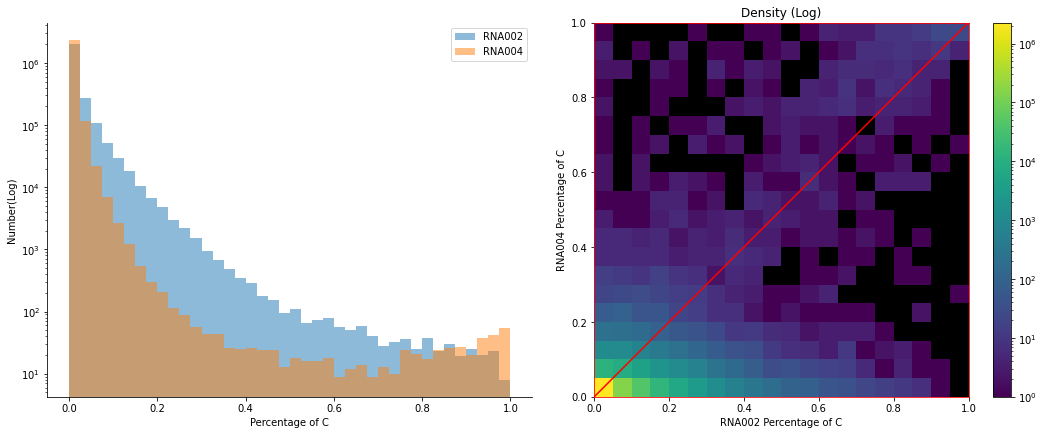

In [36]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G_cleaned_vcf.csv')

df['mismatch_perc2'] = np.where(df['ref_2'] == 'T_2', df['C_perc_2'], df['G_perc_2'])
df['mismatch_perc8'] = np.where(df['ref_8'] == 'T_8', df['C_perc_8'], df['G_perc_8'])

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(15,6)

axes= axes.flatten()
def set_spines_visibility(ax, top=False, right=False, bottom=True, left=True):
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)

bandwith_1d = .025
axes[0].set_xlabel('Percentage of C')
axes[0].set_ylabel('Number(Log)')
axes[0].hist(df['mismatch_perc2'], bins=np.arange(0,1+bandwith_1d,bandwith_1d), alpha=0.5, label='RNA002', color='tab:blue')
axes[0].hist(df['mismatch_perc8'], bins=np.arange(0,1+bandwith_1d,bandwith_1d), alpha=0.5, label='RNA004', color='tab:orange')
axes[0].set_yscale('log')
axes[0].legend()
set_spines_visibility(axes[0])

cmap = mpl.cm.viridis
cmap.set_bad('black',1.)
bandwith_2d = .05
h = axes[1].hist2d(df['mismatch_perc2'], df['mismatch_perc8'], bins=np.arange(0,1+bandwith_2d,bandwith_2d), norm=mpl.colors.LogNorm(), cmap=cmap)
axes[1].plot((0.0,1),(0.0,1), color='red', alpha=1)
axes[1].set_xlabel('RNA002 Percentage of C')
axes[1].set_ylabel('RNA004 Percentage of C')
axes[1].set_title('Density (Log)')
fig.colorbar(h[3], ax=axes[1])
axes[1].set_xlim(0.0,1)
axes[1].set_ylim(0.0,1)
axes[1].set_aspect('equal')
for spine in axes[1].spines.values():
    spine.set_color('red')

fig.tight_layout() 
plt.show()

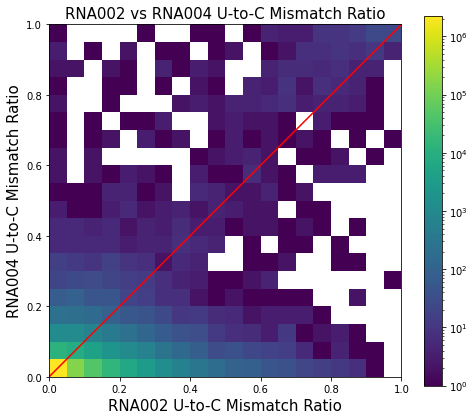

In [10]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G_cleaned_vcf.csv')

df['mismatch_perc2'] = np.where(df['ref_2'] == 'T_2', df['C_perc_2'], df['G_perc_2'])
df['mismatch_perc8'] = np.where(df['ref_8'] == 'T_8', df['C_perc_8'], df['G_perc_8'])

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)

cmap = mpl.cm.viridis
cmap.set_bad('white', 1.0)

bandwith_2d = 0.05

h = ax.hist2d(df['mismatch_perc2'], df['mismatch_perc8'], bins=np.arange(0, 1 + bandwith_2d, bandwith_2d), norm=mpl.colors.LogNorm(), cmap=cmap)

ax.plot((0.0, 1), (0.0, 1), color='red', alpha=1)

ax.set_xlabel('RNA002 U-to-C Mismatch Ratio', fontsize=15)
ax.set_ylabel('RNA004 U-to-C Mismatch Ratio', fontsize=15)
ax.set_title('RNA002 vs RNA004 U-to-C Mismatch Ratio', fontsize=15)

fig.colorbar(h[3], ax=ax)

ax.set_xlim(0.0, 1)
ax.set_ylim(0.0, 1)
ax.set_aspect('equal')

for spine in ax.spines.values():
    spine.set_color('black')

fig.tight_layout()
plt.show()

## Delta for U-to-C

In [2]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/merged_2_8_T2C_A2G_cleaned_vcf.csv')

df['mismatch_perc2'] = np.where(df['ref_2'] == 'T_2', df['C_perc_2'], df['G_perc_2'])
df['mismatch_perc8'] = np.where(df['ref_8'] == 'T_8', df['C_perc_8'], df['G_perc_8'])

In [5]:
# delta
df['delta'] = np.abs(df['mismatch_perc2'] - df['mismatch_perc8'])

rna002_higher = (df['mismatch_perc2'] - df['mismatch_perc8'] >= 0.05).sum()
rna004_higher = (df['mismatch_perc8'] - df['mismatch_perc2'] >= 0.05).sum()
within_threshold = (df['delta'] < 0.05).sum()

print(f"For {rna002_higher} sites, RNA002 was 5% higher in U-to-C mismatch.")
print(f"For {rna004_higher} sites, RNA004 was 5% higher in U-to-C mismatch.")
print(f"For {within_threshold} sites, the two chemistries were within 5% of each other.")

For 161796 sites, RNA002 was 5% higher in U-to-C mismatch.
For 5216 sites, RNA004 was 5% higher in U-to-C mismatch.
For 2363589 sites, the two chemistries were within 5% of each other.


For 161,796 sites, RNA002 showed a ≥5% higher U-to-C mismatch than RNA004.
For 5,216 sites, RNA004 showed a ≥5% higher U-to-C mismatch than RNA002.
For 2,363,589 sites, the mismatch rates between the two chemistries were within 5% of each other.

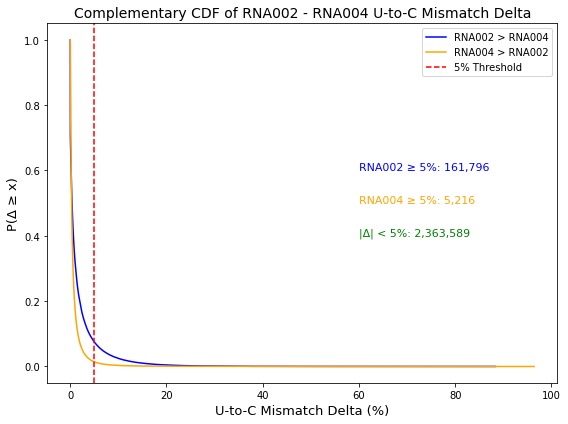

In [9]:
df['delta'] = df['mismatch_perc2'] - df['mismatch_perc8']
df['abs_delta'] = np.abs(df['delta'])

rna002_higher = (df['delta'] >= 0.05).sum()
rna004_higher = (df['delta'] <= -0.05).sum()
within_5_percent = (df['abs_delta'] < 0.05).sum()

pos_delta = df.loc[df['delta'] >= 0, 'delta']
neg_delta = -df.loc[df['delta'] < 0, 'delta']

sorted_pos = np.sort(pos_delta)
ccdf_pos = 1.0 - np.arange(1, len(sorted_pos)+1) / len(sorted_pos)

sorted_neg = np.sort(neg_delta)
ccdf_neg = 1.0 - np.arange(1, len(sorted_neg)+1) / len(sorted_neg)

x_pos = sorted_pos * 100
x_neg = sorted_neg * 100

# P(Δ ≥ x): proportion (probability) of sites where the absolute mismatch delta is greater than or equal to x
# x=|mismatch_perc2−mismatch_perc8|×100

plt.figure(figsize=(8, 6))
plt.plot(x_pos, ccdf_pos, label='RNA002 > RNA004', color='blue')
plt.plot(x_neg, ccdf_neg, label='RNA004 > RNA002', color='orange')
plt.axvline(5, color='red', linestyle='--', label='5% Threshold')

plt.text(60, 0.6, f'RNA002 ≥ 5%: {rna002_higher:,}', color='blue', fontsize=11)
plt.text(60, 0.5, f'RNA004 ≥ 5%: {rna004_higher:,}', color='orange', fontsize=11)
plt.text(60, 0.4, f'|Δ| < 5%: {within_5_percent:,}', color='green', fontsize=11)

plt.xlabel('U-to-C Mismatch Delta (%)', fontsize=13)
plt.ylabel('P(Δ ≥ x)', fontsize=13)
plt.title('Complementary CDF of RNA002 - RNA004 U-to-C Mismatch Delta', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('CDF_U-to-C_mismatch.pdf')
plt.show()

# Dorado vs U-to-C mismatch

In [4]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit.tsv', sep='\t')

filtered_df = df[(df['fraction_modified'] > 0) & (df['score'] >= 20)]

filtered_df.to_csv('/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20.tsv', sep='\t', index=False)
print(filtered_df.head())

len(filtered_df)

   chrom  start_position  end_position  modified_base_code  score strand  \
14  chr1           14420         14421               17802     39      -   
15  chr1           14424         14425               17802     44      -   
16  chr1           14446         14447               17802     43      -   
18  chr1           14455         14456               17802     44      -   
19  chr1           14456         14457               17802     39      -   

    start_position_compat  end_position_compat    color  Nvalid_cov  \
14                  14420                14421  255,0,0          39   
15                  14424                14425  255,0,0          44   
16                  14446                14447  255,0,0          43   
18                  14455                14456  255,0,0          44   
19                  14456                14457  255,0,0          39   

    fraction_modified  Nmod  Ncanonical  Nother_mod  Ndelete  Nfail  Ndiff  \
14               5.13     2          3

3625185

In [17]:
pysamstats_df = pd.read_csv('/work/Genometechlab/neda/RNA002_table_T2C_A2G.csv', sep="\t")
print(pysamstats_df.head())
len(pysamstats_df)

# RNA008 (4)
# 3528654

# RNA002
# 6625920

  chrom    pos ref   A  C  G  T    A_perc    C_perc    G_perc    T_perc
0  chr1  14447   A  69  0  1  2  0.958333  0.000000  0.013889  0.027778
1  chr1  14448   A  85  0  1  0  0.988372  0.000000  0.011628  0.000000
2  chr1  14456   A  64  9  2  3  0.820513  0.115385  0.025641  0.038462
3  chr1  14459   A  79  0  2  1  0.963415  0.000000  0.024390  0.012195
4  chr1  14483   A  83  0  1  2  0.965116  0.000000  0.011628  0.023256


6625920

In [6]:
# intersecting modkit and pysamstats

modkit_df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20.tsv', sep='\t')

pysamstats_df = pd.read_csv('/work/Genometechlab/neda/RNA008_table_T2C_A2G.csv', sep="\t")

# intersection based on the 'end_position' in modkit and 'pos' in pysamstats
intersection_df = pd.merge(modkit_df, pysamstats_df, left_on=['chrom','end_position'], right_on=['chrom','pos'])

intersection_df.to_csv('/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA8_C_G.csv', sep='\t', index=False)

print(intersection_df.head())

len(intersection_df)

# RNA008
# 1486387
# 1512369 (stu)


# RNA002
# 2240365
# 2286877 (stu)

  chrom  start_position  end_position  modified_base_code  score strand  \
0  chr1           14541         14542               17802     32      -   
1  chr1           14575         14576               17802     42      -   
2  chr1           14606         14607               17802     34      -   
3  chr1           14779         14780               17802     28      -   
4  chr1           14780         14781               17802     25      -   

   start_position_compat  end_position_compat    color  Nvalid_cov  ...  \
0                  14541                14542  255,0,0          32  ...   
1                  14575                14576  255,0,0          42  ...   
2                  14606                14607  255,0,0          34  ...   
3                  14779                14780  255,0,0          28  ...   
4                  14780                14781  255,0,0          25  ...   

     pos  ref   A  C  G  T    A_perc    C_perc    G_perc T_perc  
0  14542    A  37  1  9  0  0.78

1512369

### variant filtering

In [8]:
#Excluding variants from the intersection of modkit and pysamsats

def extract_positions_from_vcf(vcf_file):
    positions = set()
    vcf = pysam.VariantFile(vcf_file)
    for record in vcf.fetch():
        positions.add((record.chrom, record.pos))
    return positions

csv_file = '/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA8_C_G.csv'
csv_data = pd.read_csv(csv_file, sep="\t")


csv_data.columns = csv_data.columns.str.strip()

print("Columns in CSV:", csv_data.columns)

vcf_file = '/work/Genometechlab/neda/clair/RNA004_sup_vcf/merge_output.vcf.gz'
vcf_positions = extract_positions_from_vcf(vcf_file)

# Find matching positions in the CSV file
csv_positions = set(zip(csv_data['chrom'], csv_data['pos']))
matching_positions = csv_positions.intersection(vcf_positions)
num_matching_positions = len(matching_positions)

# Remove matching positions from the CSV data
cleaned_csv_data = csv_data[~csv_data[['chrom', 'pos']].apply(tuple, axis=1).isin(matching_positions)]

cleaned_csv_file = '/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA8_C_G_vcf_excluded.csv'
cleaned_csv_data.to_csv(cleaned_csv_file, index=False)

print(f'Number of matching positions: {num_matching_positions}')

print(cleaned_csv_data.head())

# RNA8
# 1197
# 1227 (stu)

# RNA2
# 1296
# 1326 (stu)

Columns in CSV: Index(['chrom', 'start_position', 'end_position', 'modified_base_code',
       'score', 'strand', 'start_position_compat', 'end_position_compat',
       'color', 'Nvalid_cov', 'fraction_modified', 'Nmod', 'Ncanonical',
       'Nother_mod', 'Ndelete', 'Nfail', 'Ndiff', 'Nnocall', 'pos', 'ref', 'A',
       'C', 'G', 'T', 'A_perc', 'C_perc', 'G_perc', 'T_perc'],
      dtype='object')
Number of matching positions: 1227
  chrom  start_position  end_position  modified_base_code  score strand  \
0  chr1           14541         14542               17802     32      -   
1  chr1           14575         14576               17802     42      -   
2  chr1           14606         14607               17802     34      -   
3  chr1           14779         14780               17802     28      -   
4  chr1           14780         14781               17802     25      -   

   start_position_compat  end_position_compat    color  Nvalid_cov  ...  \
0                  14541               

<ipython-input-13-7439ec8a4d49>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA8_C_G_vcf_excluded.csv', sep='\,')


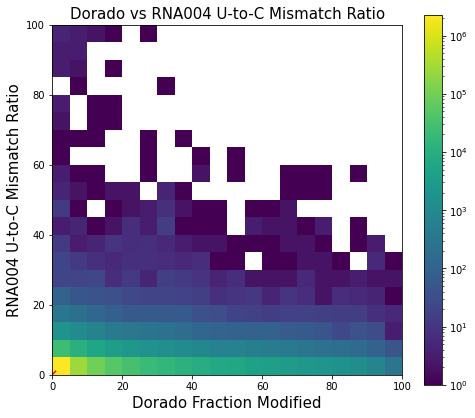

In [13]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA8_C_G_vcf_excluded.csv', sep='\,')

df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])

df['mismatch_perc']*=100

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)

cmap = mpl.cm.viridis
cmap.set_bad('white', 1.)

bandwidth_2d = 5
bins = np.arange(0, 100 + bandwidth_2d, bandwidth_2d)

hist = ax.hist2d(df['fraction_modified'], df['mismatch_perc'], bins=[bins, bins], norm=mpl.colors.LogNorm(), cmap=cmap)

ax.plot((0.0, 1), (0.0, 1), color='red', alpha=1)
ax.set_xlabel('Dorado Fraction Modified', fontsize=15)
ax.set_ylabel('RNA004 U-to-C Mismatch Ratio', fontsize=15)
ax.set_title('Dorado vs RNA004 U-to-C Mismatch Ratio', fontsize=15)
fig.colorbar(h[3], ax=ax)
ax.set_xlim(0.0, 100)
ax.set_ylim(0.0, 100)
ax.set_aspect('equal')
    

ax.tick_params(axis='both')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
fig.tight_layout()
plt.show()

<ipython-input-15-453802784248>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA2_C_G_vcf_excluded.csv', sep='\,')


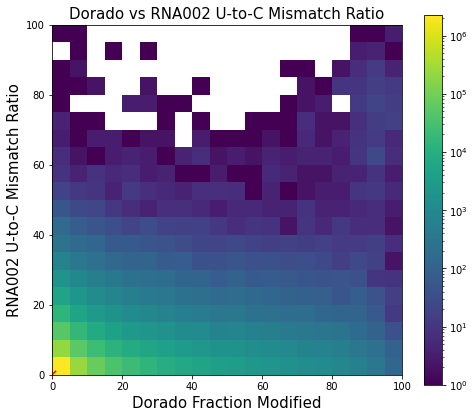

In [15]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/modkit_stu_pysamstats_RNA2_C_G_vcf_excluded.csv', sep='\,')

df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])

df['mismatch_perc']*=100

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)

cmap = mpl.cm.viridis
cmap.set_bad('white', 1.)

bandwidth_2d = 5
bins = np.arange(0, 100 + bandwidth_2d, bandwidth_2d)

hist = ax.hist2d(df['fraction_modified'], df['mismatch_perc'], bins=[bins, bins], norm=mpl.colors.LogNorm(), cmap=cmap)

ax.plot((0.0, 1), (0.0, 1), color='red', alpha=1)
ax.set_xlabel('Dorado Fraction Modified', fontsize=15)
ax.set_ylabel('RNA002 U-to-C Mismatch Ratio', fontsize=15)
ax.set_title('Dorado vs RNA002 U-to-C Mismatch Ratio', fontsize=15)
fig.colorbar(h[3], ax=ax)
ax.set_xlim(0.0, 100)
ax.set_ylim(0.0, 100)
ax.set_aspect('equal')
    

ax.tick_params(axis='both')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
fig.tight_layout()
plt.show()

# Venn diagram

Modkit filter for score =>20

pysamstats results for both RNA002 and RNA004 filtered for ref T (c, forward) or A (G, reverse) and at least on C or G, 20 reads at least

In [16]:
df = pd.read_csv('/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20.tsv', sep='\t')
filtered_df = df[(df['fraction_modified'] >= 20.0)]

filtered_df.to_csv('/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20_fraction_mod_20.tsv', sep='\t', index=False)

## Venn with excluding variants

In [20]:
def extract_positions_from_vcf(vcf_file):
    positions = set()
    vcf = pysam.VariantFile(vcf_file)
    for record in vcf.fetch():
        positions.add((record.chrom, record.pos))
    return positions

vcf_file = "/work/Genometechlab/neda/clair/RNA004_sup_vcf/merge_output.vcf.gz"
modkit_file = '/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20_fraction_mod_20.tsv'
rna002_file = "/work/Genometechlab/neda/RNA002_table_T2C_A2G_0.20.csv"
rna004_file = "/work/Genometechlab/neda/RNA008_table_T2C_A2G_0.20.csv"

vcf_positions = extract_positions_from_vcf(vcf_file)
print(f"Number of positions in VCF: {len(vcf_positions)}")

def exclude_vcf_positions(csv_file, output_file, position_column="pos"):
    df = pd.read_csv(csv_file, sep="\t")
    df.columns = df.columns.str.strip()
    csv_positions = set(zip(df['chrom'], df[position_column]))

    matching_positions = csv_positions.intersection(vcf_positions)
    print(f"Excluding {len(matching_positions)} positions from {csv_file}")

    cleaned_df = df[~df[['chrom', position_column]].apply(tuple, axis=1).isin(matching_positions)]
    cleaned_df.to_csv(output_file, sep="\t", index=False)
    
    return cleaned_df

modkit_filtered_file = '/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20_fraction_mod_20_vcf_filtered.tsv'
rna002_filtered_file = "/work/Genometechlab/neda/venn/RNA002_table_T2C_A2G_0.20_vcf_filtered.tsv"
rna004_filtered_file = "/work/Genometechlab/neda/venn/RNA008_table_T2C_A2G_0.20_vcf_filtered.tsv"

modkit_filtered = exclude_vcf_positions(modkit_file, modkit_filtered_file, position_column="end_position")
rna002_filtered = exclude_vcf_positions(rna002_file, rna002_filtered_file, position_column="pos")
rna004_filtered = exclude_vcf_positions(rna004_file, rna004_filtered_file, position_column="pos") 

Number of positions in VCF: 5773355
Excluding 104 positions from /work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20_fraction_mod_20.tsv
Excluding 6468 positions from /work/Genometechlab/neda/RNA002_table_T2C_A2G_0.20.csv
Excluding 7266 positions from /work/Genometechlab/neda/RNA008_table_T2C_A2G_0.20.csv


In [21]:
modkit_filtered_file = '/work/Genometechlab/neda/dorado_0.8.1/stuart_07_27_23_RNA004_GM12878_polyA_RNA.dorado_0.8.1_sup.moves.psi.GRCh38.modkit_score_20_fraction_mod_20_vcf_filtered.tsv'
rna002_filtered_file = "/work/Genometechlab/neda/venn/RNA002_table_T2C_A2G_0.20_vcf_filtered.tsv"
rna004_filtered_file = "/work/Genometechlab/neda/venn/RNA008_table_T2C_A2G_0.20_vcf_filtered.tsv"

modkit_filtered = pd.read_csv(modkit_filtered_file , sep= "\t")
rna002_filtered = pd.read_csv(rna002_filtered_file , sep= "\t")
rna004_filtered = pd.read_csv(rna004_filtered_file , sep= "\t")

In [22]:
modkit_positions = set(zip(modkit_filtered['chrom'], modkit_filtered['end_position'])) 
rna002_positions = set(zip(rna002_filtered['chrom'], rna002_filtered['pos']))
rna004_positions = set(zip(rna004_filtered['chrom'], rna004_filtered['pos']))

overlap_all = modkit_positions & rna002_positions & rna004_positions
overlap_modkit_rna002 = modkit_positions & rna002_positions
overlap_modkit_rna004 = modkit_positions & rna004_positions
overlap_rna002_rna004 = rna002_positions & rna004_positions

print(f"Total positions in RNA002: {len(rna002_positions)}")
print(f"Total positions in RNA004: {len(rna004_positions)}")
print(f"Total positions in Modkit: {len(modkit_positions)}")
print(f"Positions in all three conditions: {len(overlap_all)}")
print(f"Positions in RNA002 and RNA004: {len(overlap_rna002_rna004)}")
print(f"Positions in RNA002 and Modkit: {len(overlap_modkit_rna002)}")
print(f"Positions in RNA004 and Modkit: {len(overlap_modkit_rna004)}")

Total positions in RNA002: 42944
Total positions in RNA004: 14764
Total positions in Modkit: 134545
Positions in all three conditions: 124
Positions in RNA002 and RNA004: 1210
Positions in RNA002 and Modkit: 5120
Positions in RNA004 and Modkit: 379


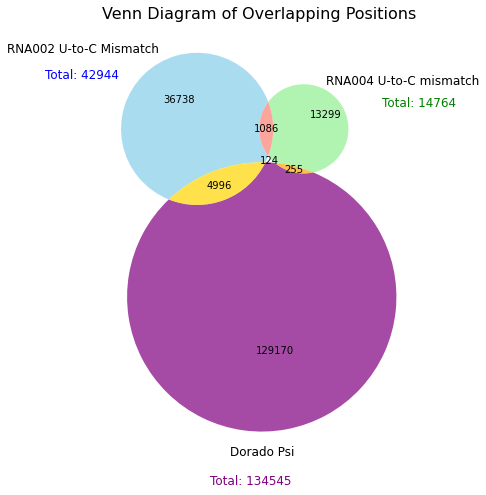

In [24]:
# filtered variant (20 reads, 20% U-to-C and psi)

plt.figure(figsize=(10, 8))
venn = venn3([rna002_positions, rna004_positions, modkit_positions],('RNA002 U-to-C Mismatch', 'RNA004 U-to-C mismatch', 'Dorado Psi'))

for patch, color in zip(venn.patches, ['skyblue', 'lightgreen', 'salmon', 'purple', 'gold', 'orange', 'gray']):
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

plt.text(-0.6, 0.6, f"Total: {len(rna002_positions)}", fontsize=12, color='blue', ha='center')
plt.text(0.6, 0.5, f"Total: {len(rna004_positions)}", fontsize=12, color='green', ha='center')
plt.text(0.0, -0.85, f"Total: {len(modkit_positions)}", fontsize=12, color='purple', ha='center')

plt.title('Venn Diagram of Overlapping Positions', fontsize=16)
plt.show()